# 3 - Reconstituer les lignes très haute tension

Dans ce notebook on allons trouver un point sensible que nous allons viser

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pants
import math
import random

In [2]:
# Charger le fichier csv, en ne prenant que les colonnes d'indices 8 et 9
# la latitude/longitude des emplacements de pylones
# les donnees proviennent d'ODRE
# https://opendata.reseaux-energies.fr/explore/dataset/pylones-rte/information/?disjunctive.etat&disjunctive.tension
df = pd.read_csv('data/db/pylones-rte.csv', sep=';', usecols=[8,9], low_memory=False)


def euclidean(a, b):
    return math.sqrt(pow(a[1] - b[1], 2) + pow(a[0] - b[0], 2))

## Approche 2

On cherche à estimer, sachant les positions des differents pylônes, la répartition des lignes RTE.<br/>
On prend donc l'angle d'un graphe, en se rapprochant du 
<a href="https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce">problème du marchand ambulant</a>.<br/>
    
Dans le but de garder un modèle concis, et résolvable dans la fenêtre de temps imparti, nous partons du postulat que le carte de France des lignes très haute tension (THT) s'apparente au plus petit graphe connecté ayant pour sommets les pylônes et comme arêtes les lignes.
Nous pourrions toutefois étoffer ce modèle en prenant en compte:
 - Les sorties de lieux de production (barrages, centrales et ainsi de suite)
 - les intersections entre les lignes THT
 - les lignes HT, MT et BT.
 - les points de livraisons

Nous allons donc chercher a trouver les arêtes d'un graphe dont nous connaissons les sommets.<br/>
Optimisation n! => O(nlog(n)); voir <a href="https://www.sciencedirect.com/science/article/abs/pii/S0020019007002190">ce papier</a> pour plus d'informations.<br/>

In [3]:
print(len(df))

260252


La solution classique pour trouver le plus petit graphe est de l'ordre de *n!*

Pour rappel, 260000! est infiniment supérieur au nombre de particules dans l'univers.<br/> 
Il semble ambitieux d'appliquer une solution de cet ordre de grandeur...

### Nous avons donc besoin d'une optimisation

### <u>Optimisation de la colonie de fourmis</u>

Cette <a href="https://fr.wikipedia.org/wiki/Algorithme_de_colonies_de_fourmis">optimisation</a> permettrait de réduire la classe de complexité de *n!* a *nlog(n)*, d'après <a href="https://www.sciencedirect.com/science/article/pii/S0304397510007218"> ce papier de recherche</a>

260000 * log(260000) est de l'ordre de 10^
#### <u> C'est déja bien plus abordable! </u>
    
    
Toutefois, nous allons nous concentrer sur une fraction du territoire francais, en l'occurence un département, de par les contraintes de temps et de puissance de calcul!

### Création du graphe

Nous avons donc fait tourner notre algorithme sur un département français que nous avons sélectionné en fonction de:
- le nombre d'entreprise de la BITD
- la cartographie énergétique
- la simplicité d'exploitation

L'algorithme mettant un certain temps à s'exécuter, son code source est dans src/graph_department.py et nous avons stocké le graphe résultant dans data/ligne_THT.graph.

Pour pouvoir l'analyser et en extraire des conclusions, il est nécessaire de le visualiser.

In [4]:
import hvplot.networkx as hvnx
import networkx as nx
import holoviews as hv
import matplotlib.pyplot as plt
import pickle

In [5]:
a = pickle.load(open('data/ligne_THT.graph', 'rb'))

In [6]:
G = nx.Graph()
dict_a = dict()
len_graph = len(a)
for i in range(len_graph):
    dict_a[i] = a[i]

In [7]:
# [1 : [-3.1231, 48.54645]]
G.add_nodes_from(dict_a.keys())
for i in range(len_graph - 1):
    G.add_edge(i, i + 1)

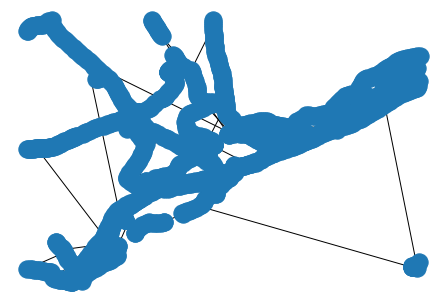

In [8]:
nx.draw(G, dict_a)
plt.show()

Nous avons donc choisi les alentours de St Etienne. <br>
Nous pouvons reconnaître ci-dessus une estimation des lignes THT de la zone.<br>
Toutefois, afin de pouvoir traiter le graphe point par point, nous allons faire un hvnx.draw().

In [9]:
hvnx.draw(G, dict_a, xlabels='Longitude', ylabel = 'Latitude', node_color='club', cmap='Category10', width=1000, height=1000)

:Graph   [start,end]

Nous pouvons donc voir les pylônes de la région ainsi que leurs dépendances. <br>
Par ailleurs, nous pouvons reconnaître que 2 groupes dependent d'une seule série de pylônes, dont l'index
est situé autour de l'index 1040 sur le graphique ci-dessus.

## Ce que nous avons fait
- Choisi une zone sensible du territoire (énergie + entreprise stratégiques)
- Estimé les lignes THT de la zone grâce à de la théorie des graphes
- Repéré des **sensibilités** dans le réseau THT